# Practical for Seasonal Forecasts
In this practical, we will use some forecast models to generate some seaonal precipitation forecasts, and then assess how their raw forecasts compared with a technique to bias correct (i.e. postprocess) their outputs.

The postprocessing technique assessed is Canonical Correlation Analysis (CCA), which bias corrects forecasts by seeking patterns across large spatial domains using Empirical Orthogonal Functions (EOFs).

The usefulness of this technique also depends on the observations used to train the model, we will compare data from University of California at Santa Barbara (UCSB) CHIRPS 5km rainfall data and CMORPH 0.25' data as options to train the CCA bias correction technique.

**This notebook should be run in the intdesk_train environment - check your kernel (upper righthand corner) is set to 'intdesk_train', so you have all necessary libraries**


## Libraries

In [31]:
import xcast as xc
import datetime as dt
from datetime import datetime
import numpy as np
from pathlib import Path
import xarray as xr
import os
import time
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import glob

# import rioxarray
# import geopandas as gpd
# from shapely.geometry import mapping

# automatically reloads the configuration file once updated and saved so you don't have to restart the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Project Directory Setup

In [32]:
# setup the folder where you want to work for this project
# either type in the location, or place this notebook in the folder where you want your project to live and set project_dir = os.getcwd()
project_dir = os.getcwd()#"/Users/katie/Desktop/trial_pacisl" 

#make subdirectores to organize your work within the project if they don't already exist
os.makedirs(os.path.join(project_dir, 'practical_data'), exist_ok = True)
data_dir = os.path.join(project_dir, 'practical_data')
os.makedirs(os.path.join(data_dir, 'nc_files'), exist_ok = True)
nc_dir = os.path.join(data_dir, 'nc_files')
os.makedirs(os.path.join(project_dir, 'practical_figures'), exist_ok = True)
figure_dir = os.path.join(project_dir, 'practical_figures')

#shapefile directory
boundary_dir = os.path.join(project_dir, 'pacific_shapefile')

## Pick your Models, Observational Data, and Initialization Date

In [51]:
#PICK YOUR MODELS to compare raw vs. bias corrected results
gcms = ['NMME']#'GEOSS2S','SPEAR', 'CCSM4', 'CanSIPSIC3', 'CFSv2', 

#PICK YOUR OBSERVATIONAL RAINFALL DATASET to evaluate predictions
# options include 'CHIRPS', or 'CMORPH'
obs_name = 'CHIRPS'

## PICK YOUR DATE you want to initialize the model, e.g. your current date
initial_date = (2023, 7, 1)

#where you want to target your final analysis
#some predefined zones, update the numbers or add another zone following the same labelling structure
fiji_coordinates = {
        'west':  177,
        'east': 182,  
        'north': -15,  
        'south': -20}

kiribati_coordinates = {
        'west':  202,
        'east': 203,  
        'north': 3,  
        'south': 1}

solomon_coordinates = {
        'west':  155,
        'east': 167,  
        'north': -6,  
        'south': -13}

png_coordinates = {
        'west':  130,
        'east': 156,  
        'north': 1,  
        'south': -12}

### PICK YOUR ZONE OF INTEREST
region_of_interest = 'Fiji' #how you want to name your region (can include spaces)
region_coords = fiji_coordinates #name of the coordinates to use for your region, as defined above

## Prepare Data for Analysis

### Calculate Seasons to Forecast Based on Initialization Date

In [52]:
#this cell is setup to calculate your target forecast months based on your initialization date
#the forecast months are currently seto to be 1-3, 2-4 and 3-5 months ahead
number_to_month_name_dictionary = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec',
    0: 'Dec'
}

leads = [['1', '3'],['2', '4'], ['3','5']]
initial_month = dt.datetime(*initial_date).month
initial_month_name = number_to_month_name_dictionary[initial_month]
target_seas = []
for l in leads:
    target_low = number_to_month_name_dictionary[(initial_month + float(l[0]))%12]
    target_high = number_to_month_name_dictionary[(initial_month + float(l[1]))%12]
    target_seas.append('-'.join([target_low, target_high]))
print('Target seasons to forecast')
print(target_seas)

Target seasons to forecast
['Aug-Oct', 'Sep-Nov', 'Oct-Dec']


### Load Observations and Model Data

In [53]:
#raster tools
import rasterio.features as features
import geopandas as gpd
#parallelization tools
import dask
from dask.distributed import LocalCluster, Client
import concurrent.futures

##### location functions to crop large datasets to shapfiles of interest
#inputs: xarray dataset, shapefile
#ouputs: cropped dataset
def crop_ds_with_shapefile(ds, shapefile):

    # Define the geobox dimensions and coordinates
    y_coords = ds.coords['Y'].values
    x_coords = ds.coords['X'].values

    # Calculate the pixel sizes
    x_resolution = (x_coords[-1] - x_coords[0]) / (len(x_coords) - 1)
    y_resolution = (y_coords[-1] - y_coords[0]) / (len(y_coords) - 1)
    x_min = x_coords[0]  # Specify the minimum x value
    y_min = y_coords[0]  # Specify the minimum y value

    # Calculate the maximum x and y values based on the dataset size and resolution
    x_max = x_min + (len(x_coords) - 1) * x_resolution
    y_max = y_min + (len(y_coords) - 1) * y_resolution

    # Define the transform matrix
    transform = (x_resolution, 0.0, x_min, 0.0, -y_resolution, y_max)
    ds.attrs['crs'] = 'EPSG:4326'
    # Reproject the shapefile to match the dataset CRS if necessary
    shapefile = shapefile.to_crs(ds.attrs['crs'])

    # Create the mask
    mask_shape = (len(ds.coords['Y'].values), len(ds.coords['X'].values))
    print(mask_shape)
    mask = features.geometry_mask(
        shapefile.geometry,
        out_shape=mask_shape,
        transform=transform,
        invert=True,
    )

    # Swap the dimensions of the mask array
    mask = mask[::-1, :]
    # Create a dask cluster and client for parallel processing
    cluster = dask.distributed.LocalCluster(dashboard_address=':8888')
    client = dask.distributed.Client(cluster)
    # Subset the dataset using the mask in parallel
    cropped_ds = ds.map(lambda x: x.where(xr.DataArray(mask, dims=['Y', 'X']), drop=True), keep_attrs=True)

    # Compute the result
    cropped_ds = cropped_ds.compute()
    # Close the dask client and cluster
    client.close()
    cluster.close()

    return cropped_ds

ModuleNotFoundError: No module named 'rasterio'

In [54]:
if obs_name == 'CMORPH':
    training_length = 'threeseas'
elif obs_name == 'CHIRPS':
    training_length = 'oneseas'
obs_leads = xr.open_dataset(os.path.join(nc_dir, '_'.join([initial_month_name, training_length, obs_name, 'precip.nc'])))

#train the model on observations over a grid slightly larger than the region of interest
predictand_train_extent = {
    'west':  region_coords['west']-5,
        'east': region_coords['east']+5,  
        'north': region_coords['north']+3,  
        'south': region_coords['south']-2
}
obs_leads = obs_leads.sel(X=slice(predictand_train_extent['west'], predictand_train_extent['east']),
                          Y=slice(predictand_train_extent['south'], predictand_train_extent['north']))
print(obs_leads)

#if using cmorph data, crop cmorph data using an ocean mask 

# if obs_name == 'CMORPH':
#     obs_leads = obs_leads.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
#     obs_leads = obs_leads.rio.write_crs("EPSG:4326")
#     shapefile = gpd.read_file(os.path.join(boundary_dir, 'pacific.shp'))
#     if shapefile.crs is None:
#         shapefile.set_crs("EPSG:4326", inplace=True)
#     if shapefile.crs != obs_leads.rio.crs:
#         shapefile = shapefile.to_crs(obs_leads.rio.crs)
#     masked_obs = obs_leads.rio.clip(shapefile.geometry.apply(mapping), shapefile.crs)

# read in hindcast and forecast data
hindcast_data, forecast_data = [], []
for gcm in gcms:
    g = xr.open_dataset(os.path.join(nc_dir, '_'.join([initial_month_name, training_length, gcm, 'hcst_precip.nc'])))
    f = xr.open_dataset(os.path.join(nc_dir, '_'.join([initial_month_name, training_length, gcm, 'fcst_precip.nc'])))
    hindcast_data.append(g)
    forecast_data.append(f)
hindcast_data = xr.concat(hindcast_data, dim = 'M')
forecast_data = xr.concat(forecast_data, dim = 'M')

<xarray.Dataset>
Dimensions:  (L: 3, M: 1, Y: 160, X: 300, T: 32)
Coordinates:
  * L        (L) int64 1 2 3
  * M        (M) int64 0
  * Y        (Y) float32 -19.98 -19.93 -19.88 -19.83 ... -12.12 -12.08 -12.03
  * X        (X) float32 172.0 172.1 172.1 172.2 ... 186.8 186.9 186.9 187.0
  * T        (T) datetime64[ns] 2023-07-01 2024-07-01 ... 2053-07-01 2054-07-01
Data variables:
    precip   (T, L, M, Y, X) float32 ...


#### check your region of interest is what you want

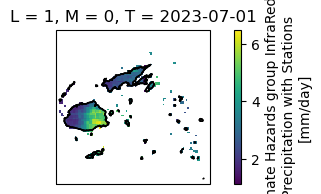

In [55]:
obs_check = obs_leads.sel(X=slice(region_coords['west'], region_coords['east']),
                          Y=slice(region_coords['south'], region_coords['north']))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,2), 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Your plotting code here using the specific model and season
xplot = obs_check.isel(T=0, L=0).precip.plot(ax=axes,
                                 transform=ccrs.PlateCarree())
axes.coastlines()
c = axes.coastlines()
# Add country borders
axes.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                    scale='50m', edgecolor='black', facecolor='none'))
# Set the extent to cover the specific area
axes.set_extent([region_coords['west'], region_coords['east'], region_coords['south'], region_coords['north']], crs=ccrs.PlateCarree())

## Analysis

### Bias correct raw model outputs using Canonical Correlation Analysis (CCA)

In [56]:
start_time = time.time()
cca_fcsts_prob, cca_fcsts_det, cca_hcasts_det, cca_hcasts_prob, obs_to_test = [],[],[],[],[]

for l in np.unique(hindcast_data.L):
    model = hindcast_data.sel(L=l).precip
    obs = obs_leads.sel(L=l).precip
    fmodel = forecast_data.sel(L=l).precip

    #run CCA
    hindcasts_det, hindcasts_prob, obs_test = [], [], []
    i=1
    for xtrain, ytrain, xtest, ytest in xc.CrossValidator(model, obs, window=5):
        print("window {}".format(i))
        i += 1
        reg = xc.CCA(search_override=(8,
                                      8,
                                     3))
        reg.fit(xtrain, ytrain)
        preds = reg.predict(xtest)
        probs =  reg.predict_proba(xtest)
        obs_test.append(ytest)
        hindcasts_det.append(preds)
        hindcasts_prob.append(probs)
    hindcasts_det = xr.concat(hindcasts_det, 'T')
    hindcasts_prob = xr.concat(hindcasts_prob, 'T')
    obs_test = xr.concat(obs_test, 'T')
    
    fprobs =  reg.predict_proba(fmodel)
    
    cca_fcsts_prob.append(fprobs)
    cca_hcasts_det.append(hindcasts_det)
    cca_hcasts_prob.append(hindcasts_prob)
    obs_to_test.append(obs_test)
cca_fcsts_prob = xr.concat(cca_fcsts_prob, dim = 'L')
cca_hcasts_det = xr.concat(cca_hcasts_det, dim = 'L')
cca_hcasts_prob = xr.concat(cca_hcasts_prob, dim = 'L')
obs_to_test = xr.concat(obs_to_test, dim = 'L')
print('cca processing time is ' + str(time.time() - start_time))

window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24
window 25
window 26
window 27
window 28
window 29
window 30
window 31
window 32
window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24
window 25
window 26
window 27
window 28
window 29
window 30
window 31
window 32
window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24
window 25
window 26
window 27
window 28
window 29
window 30
window 31
window 32
cca processing time is 153.23215866088867


## Evaluate Performance of Raw vs Bias Corrected Models

#### Pearson Correlation Coefficient

In [57]:
start_time = time.time()
#calculate pearson correlation score for hindcasts
pearson_cca, pearson_raw = [], []
for l, lead in enumerate(np.unique(hindcast_data.L.values)):
    cca_pearson_calc = xc.Pearson(cca_hcasts_det.isel(L=l),obs_to_test.isel(L=l))
    cca_pearson_calc = cca_pearson_calc.expand_dims({'M':['CCA Across Models']})

    #regrid raw data for pearson calculation on one to one grid
    raw_regrid = xc.regrid(hindcast_data.isel(L=l).precip, obs_leads.X, obs_leads.Y)
    
    #calc pearson correlation
    pearson_raw_calc = []
    for m, model in enumerate(np.unique(raw_regrid.M.values)):
        pearson_raw_c = xc.Pearson(raw_regrid.sel(M=model).expand_dims({'M':[model]}), 
                                           obs_leads.isel(L=l).precip)
        pearson_raw_c = pearson_raw_c.expand_dims({'M':[model]})
        pearson_raw_calc.append(pearson_raw_c)
    pearson_raw_calc = xr.concat(pearson_raw_calc, dim = 'M')
    pearson_cca.append(cca_pearson_calc)
    pearson_raw.append(pearson_raw_calc)
pearson_cca = xr.concat(pearson_cca, dim = 'L')
pearson_raw = xr.concat(pearson_raw, dim = 'L')
pearsons = xr.concat([pearson_cca, pearson_raw], dim = 'M')
print('pearson processing time is ' + str(time.time() - start_time))

pearson processing time is 8.42237901687622


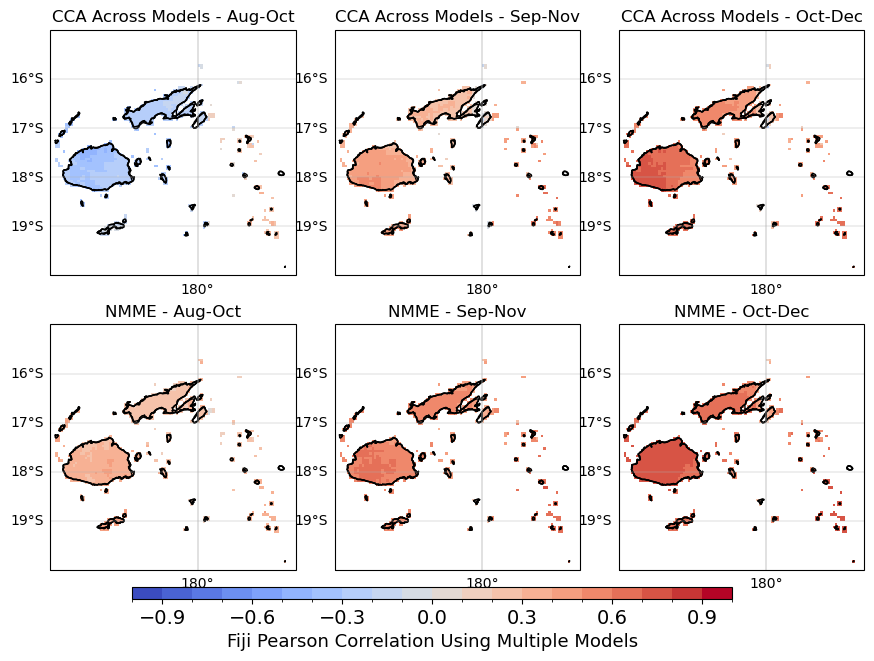

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature

# Assuming you have data for models and seasons
models = np.unique(pearsons.M.values)
seasons = target_seas.copy()

fig, axes = plt.subplots(nrows=len(models), ncols=len(seasons), figsize=(10, (len(gcms)+1)*2 + 2), 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set the extent to cover the entire world
for ax in axes.flat:
    ax.set_global()

for j, model in enumerate(models):
    for i, season in enumerate(seasons):
        ax = axes[j, i]
        # Your plotting code here using the specific model and season
        xplot = pearsons.isel(L=i, M=j).plot(ax=ax,
                                              transform=ccrs.PlateCarree(),
                                              cmap='coolwarm', levels=21, vmin=-1, vmax=1, add_colorbar=False)
        ax.coastlines()
        c = ax.coastlines()
        c = ax.gridlines(draw_labels=True, linewidth=0.3)
        c.right_labels = False
        c.top_labels = False 
        # Add country borders
        ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                            scale='50m', edgecolor='black', facecolor='none'))
        # Set the extent to cover the specific area
        ax.set_extent([region_coords['west'], region_coords['east'], region_coords['south'], region_coords['north']], crs=ccrs.PlateCarree())
        ax.set_title(f'{model} - {season}')

# Add a single horizontal colorbar below the panel plot
cbar_ax = fig.add_axes([0.15, 0.002, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(xplot, cax=cbar_ax, orientation='horizontal', shrink =1, pad = 0.3)
cbar.set_label(region_of_interest + ' Pearson Correlation Using Multiple Models', fontsize=13)
cbar.ax.tick_params(labelsize=14)
# Adjust layout
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.01, hspace=0.2)

# Show plot
plt.savefig(os.path.join(figure_dir, '_'.join([initial_month_name, region_of_interest, 'pearson_CCA', obs_name.split('.')[0]])), bbox_inches='tight', dpi=100)

#### Root Mean Squared Error (RMSE) Skill Score

In [59]:
#anomalize your data
def std_anomalize(x):
    clim = x.mean(dim='T')
    standard_dev = x.std(dim='T')
    anom = x - clim
    std_anom = anom/standard_dev
    return std_anom

#calculate the root mean squared error for each point across time
def RMSE(x, y): 
  # x is Nx1, y is Nx1
  squared_error = (x - y)**2 
  mean_squared_error = squared_error.mean(dim = 'T') 
  return np.sqrt(mean_squared_error) 

#calculate the skill score using RMSE by comparing performance of the climatology against your data
def RMSESS(x,y):
    clim = y.mean(dim='T')
    rmse_model = RMSE(x,y)
    rmse_clim = RMSE(clim,y)
    rmsess = 1 - rmse_model/rmse_clim
    return rmsess

In [60]:
start_time = time.time()
#anomalize the cca and obs_test data
obs_test_anom = std_anomalize(obs_to_test)
cca_hcasts_anom = std_anomalize(cca_hcasts_det)

#calculate pearson correlation score for hindcasts
rmse_cca, rmse_raw = [], []
for l, lead in enumerate(np.unique(hindcast_data.L.values)):
    cca_rmse_calc = RMSESS(cca_hcasts_anom.isel(L=l),obs_test_anom.isel(L=l))
    cca_rmse_calc = cca_rmse_calc.isel(M=0).expand_dims({'M':['CCA on NMME']})

    #regrid raw data for pearson calculation on one to one grid
    raw_regrid = xc.regrid(hindcast_data.isel(L=l).precip, obs_leads.X, obs_leads.Y)

    #anomalize the raw model data and obs data over the original time frame
    raw_anom = std_anomalize(raw_regrid)
    obs_anom = std_anomalize(obs_leads.precip)
    
    #calc rmse for raw values
    rmse_raw_calc = []
    for m, model in enumerate(np.unique(raw_regrid.M.values)):
        rmse_raw_c = RMSESS(raw_anom.sel(M=model), 
                                           obs_anom.isel(L=l))
        rmse_raw_c = rmse_raw_c.isel(M=m).expand_dims({'M':[model]})
        rmse_raw_calc.append(rmse_raw_c)
    rmse_raw_calc = xr.concat(rmse_raw_calc, dim = 'M')
    rmse_cca.append(cca_rmse_calc)
    rmse_raw.append(rmse_raw_calc)
rmse_cca = xr.concat(rmse_cca, dim = 'L')
rmse_raw = xr.concat(rmse_raw, dim = 'L')
rmsess = xr.concat([rmse_cca, rmse_raw], dim = 'M')
print('RMSE-SS processing time is ' + str(time.time() - start_time))

RMSE-SS processing time is 2.316786289215088


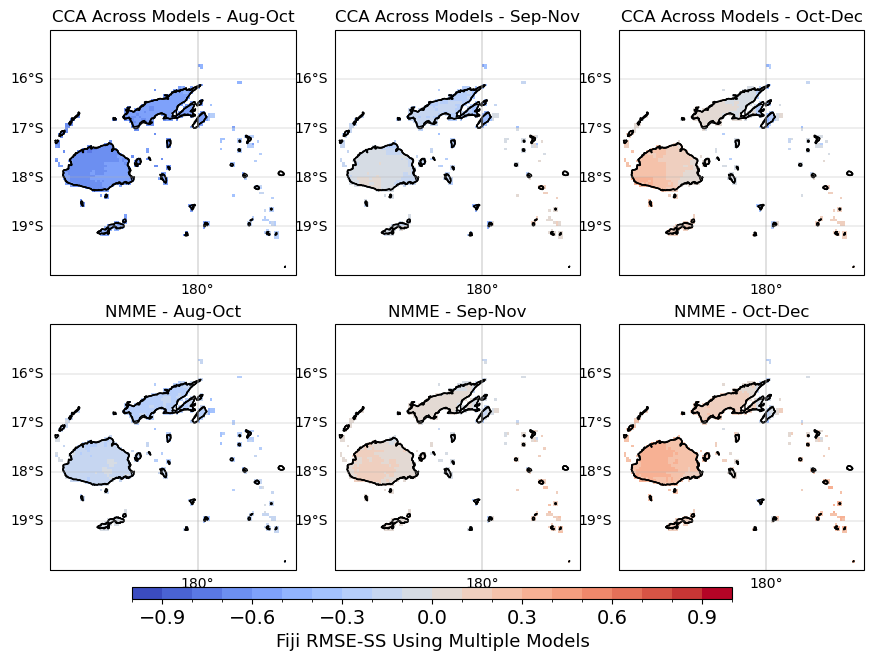

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature

# Assuming you have data for models and seasons
models = np.unique(pearsons.M.values)
seasons = target_seas.copy()

fig, axes = plt.subplots(nrows=len(models), ncols=len(seasons), figsize=(10, (len(gcms)+1)*2 + 2), 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set the extent to cover the entire world
for ax in axes.flat:
    ax.set_global()

for j, model in enumerate(models):
    for i, season in enumerate(seasons):
        ax = axes[j, i]
        # Your plotting code here using the specific model and season
        xplot = rmsess.isel(L=i, M=j).plot(ax=ax,
                                              transform=ccrs.PlateCarree(),
                                              cmap='coolwarm', levels=21, vmin=-1, vmax=1, add_colorbar=False)
        ax.coastlines()
        c = ax.coastlines()
        c = ax.gridlines(draw_labels=True, linewidth=0.3)
        c.right_labels = False
        c.top_labels = False 
        # Add country borders
        ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                            scale='50m', edgecolor='black', facecolor='none'))
        # Set the extent to cover the specific area
        ax.set_extent([region_coords['west'], region_coords['east'], region_coords['south'], region_coords['north']], crs=ccrs.PlateCarree())
        ax.set_title(f'{model} - {season}')

# Add a single horizontal colorbar below the panel plot
cbar_ax = fig.add_axes([0.15, 0.002, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(xplot, cax=cbar_ax, orientation='horizontal', shrink =1, pad = 0.3)
cbar.set_label(region_of_interest + ' RMSE-SS Using Multiple Models', fontsize=13)
cbar.ax.tick_params(labelsize=14)
# Adjust layout
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.01, hspace=0.2)

# Show plot
plt.savefig(os.path.join(figure_dir, '_'.join([initial_month_name, region_of_interest, 'RMSE-SS_CCA', obs_name.split('.')[0]])), bbox_inches='tight', dpi=100)

#### Generalized Receiver Operating Characteristics Score (GROCS)

In [130]:
start_time = time.time()
#calculate pearson correlation score for hindcasts
grocs_cca, grocs_raw = [], []
for l, lead in enumerate(np.unique(hindcast_data.L.values)):
    cca_grocs_calc = xc.GROCS(cca_hcasts_prob.isel(L=l),obs_to_test.isel(L=l))
    cca_grocs_calc = cca_grocs_calc.expand_dims({'M':['CCA on NMME']})

    #regrid raw data for pearson calculation on one to one grid
    #raw_regrid = xc.regrid(hindcast_data.isel(L=l).precip, obs_leads.X, obs_leads.Y)
    
    # #calc pearson correlation
    # pearson_raw_calc = []
    # for m, model in enumerate(np.unique(raw_regrid.M.values)):
    #     pearson_raw_c = xc.Pearson(raw_regrid.sel(M=model).expand_dims({'M':[model]}), 
    #                                        obs_leads.isel(L=l).precip)
    #     pearson_raw_c = pearson_raw_c.expand_dims({'M':[model]})
    #     pearson_raw_calc.append(pearson_raw_c)
    # pearson_raw_calc = xr.concat(pearson_raw_calc, dim = 'M')
    grocs_cca.append(cca_grocs_calc)
    #pearson_raw.append(pearson_raw_calc)
grocs_cca = xr.concat(grocs_cca, dim = 'L')
#pearson_raw = xr.concat(pearson_raw, dim = 'L')
#pearsons = xr.concat([pearson_cca, pearson_raw], dim = 'M')
print('grocs processing time is ' + str(time.time() - start_time))

grocs processing time is 17.482110738754272


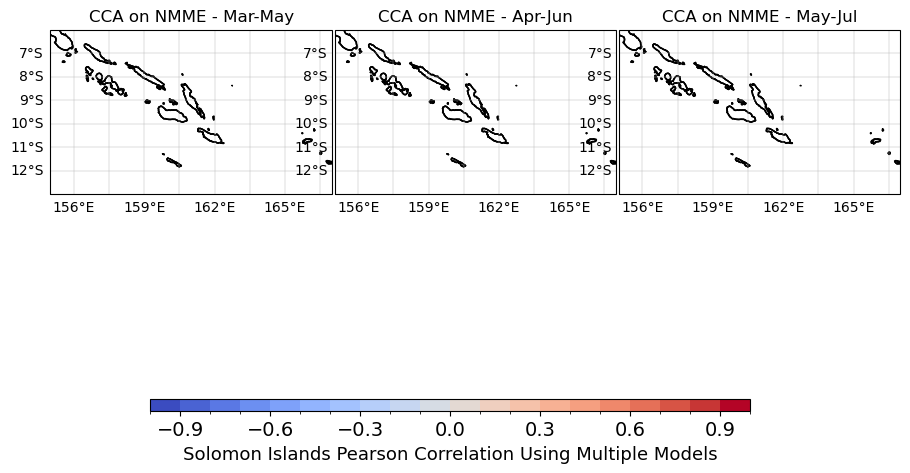

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature

# Assuming you have data for models and seasons
#models = np.unique(pearsons.M.values)
seasons = target_seas.copy()

fig, axes = plt.subplots(nrows=1, ncols=len(seasons), figsize=(10, (len(gcms)+1)*2 + 2), 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set the extent to cover the entire world
for ax in axes.flat:
    ax.set_global()

for j, model in enumerate(grocs_cca.M.values):
    for i, season in enumerate(seasons):
        ax = axes[i]##, i]
        # Your plotting code here using the specific model and season
        xplot = grocs_cca.isel(L=i, M=j).plot(ax=ax,
                                              transform=ccrs.PlateCarree(),
                                              cmap='coolwarm', levels=21, vmin=-1, vmax=1, add_colorbar=False)
        ax.coastlines()
        c = ax.coastlines()
        c = ax.gridlines(draw_labels=True, linewidth=0.3)
        c.right_labels = False
        c.top_labels = False 
        # Add country borders
        ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                            scale='50m', edgecolor='black', facecolor='none'))
        # Set the extent to cover the specific area
        ax.set_extent([region_coords['west'], region_coords['east'], region_coords['south'], region_coords['north']], crs=ccrs.PlateCarree())
        ax.set_title(f'{model} - {season}')

# Add a single horizontal colorbar below the panel plot
cbar_ax = fig.add_axes([0.15, 0.002, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(xplot, cax=cbar_ax, orientation='horizontal', shrink =1, pad = 0.3)
cbar.set_label(region_of_interest + ' GROCS Using Multiple Models', fontsize=13)
cbar.ax.tick_params(labelsize=14)
# Adjust layout
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.01, hspace=0.2)

# Show plot
plt.savefig(os.path.join(figure_dir, '_'.join([initial_month_name, region_of_interest, 'GROCS_CCA', obs_name.split('.')[0]])), bbox_inches='tight', dpi=100)

## Plot some Probabalistic Plots

### Plot the Bias Corrected Forecasts using CCA

UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']
UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']
UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']


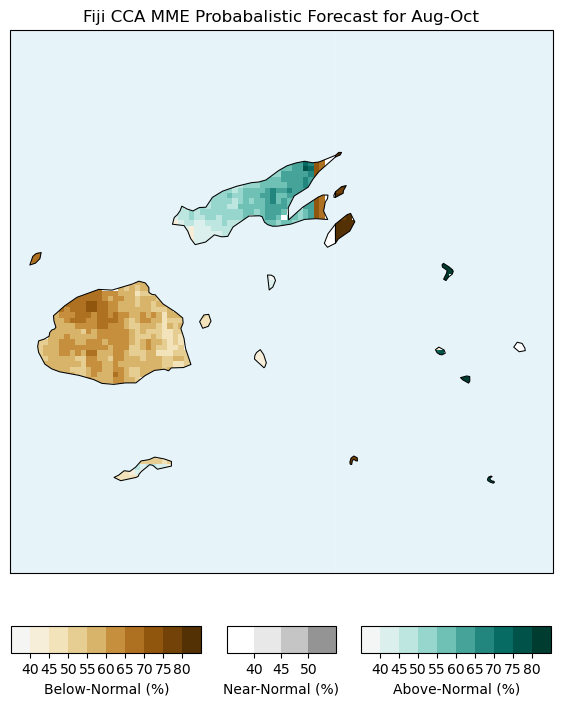

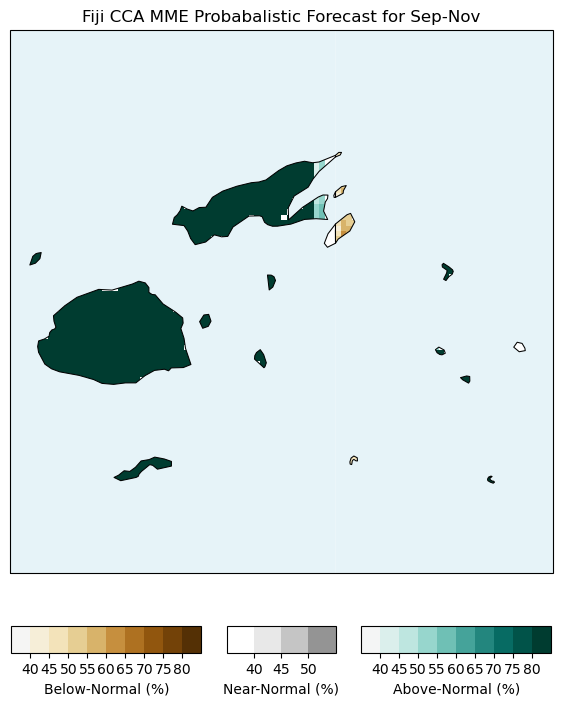

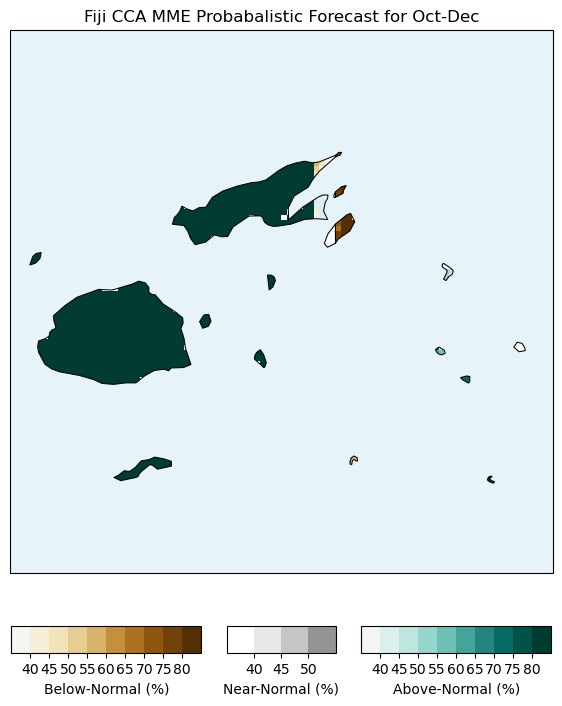

In [62]:
for l, lead in enumerate(np.unique(cca_fcsts_prob.L)):
    im = xc.view_probabilistic(cca_fcsts_prob.isel(T=0, L=l).sel(X=slice(region_coords['west'], region_coords['east']),
                                                                   Y=slice(region_coords['south'], region_coords['north'])), cross_dateline=True,
                             title= region_of_interest + ' CCA MME Probabalistic Forecast for ' + target_seas[l],
                             savefig=os.path.join(figure_dir, '_'.join(['im' + initial_month_name, target_seas[l],region_of_interest,'CCA_forecast',obs_name + '.png'])))

#### Next Steps
~~1. Add environment install command to beginning of notebook~~
 Test our environment is stable on Windows with final version - install the environment on windows; and run this notebook
~~3. Test our environment is stable round two - instlal the environment on linux; and run this notebook
Give our document to others to test - Grace and Ehsan to run~~
Process other models in addition to NMME
Download data for other seasons (4 season skill) and upload to google drive
Run CCA on 5km UCSB and 25km CMORPH and time how long it takes
Add GROC skill score
Add RMSE skill score
Plot Raw Correlation score and CHECK
Plot Bias Corrected Correlation score
Develop an assignment for the practical session- divide into 4 teams; dividing by seasons - each calculate the raw score, bias corrected, plot the probabalistic forecast
Fix figure saving

Current run time for CCA
- 77 seconds for 25'; 35 seconds for 5km

In [ ]:
ohc = xc.OneHotEncoder() 
ohc.fit(obs.rename({'lat':'Y', 'lon':'X', 'time':'T'}))
#T = ohc.transform(obs)
# clim = xr.ones_like(T) * 0.333
# print(T)
# groc=xc.GROCS(hindcasts_prob1, T)
# pl=xc.view(groc,title='GROCS',cmap=plt.get_cmap('RdBu',8),vmin=0,vmax=1)

In [ ]:
# Create a figure
fig = plt.figure(figsize=(30, 20))

# Iterate over each month and plot the data
for i, month in enumerate(range(1, 33)):
    #print(month)
    # Add subplot to the figure
    ax = fig.add_subplot(8, 4, i+1, projection=ccrs.PlateCarree(central_longitude=180))

    # Plot data for the current month
    im =hindcasts_det1.isel(M=0, time=i).plot(transform=ccrs.PlateCarree(),
                                              subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
                                             vmin=0,vmax=10)

In [ ]:
# Create a figure
fig = plt.figure(figsize=(30, 20))

# Iterate over each month and plot the data
for i, month in enumerate(range(1, 33)):
    #print(month)
    # Add subplot to the figure
    ax = fig.add_subplot(8, 4, i+1, projection=ccrs.PlateCarree(central_longitude=180))

    # Plot data for the current month
    im =obs.isel(year=i).plot(transform=ccrs.PlateCarree(),
                                              subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
                                             vmin=0,vmax=10)

In [ ]:
hindcasts_det.isel(M=0,time=3).plot()

In [ ]:
splot = chirps_pacisl.precip.plot(col = 'time', col_wrap = 5,subplot_kws={'projection':ccrs.PlateCarree()})
                                  # (transform.ccrs.PleteCareer(), vmin=0, vmax = 600, levels=21)
#splot = splot.plot(transform.ccrs.PleteCareer(), vmin=0, vmax = 600, levels=21)
for ax in  splot.axs.flat:
    coasts = ax.coastlines()
    ax.set_xlim(pred_w, pred_e)
    ax.set_ylim(pred_s, pred_n)
plt.show()

In [ ]:
hmodelt = nmme_mme_hcst.precip.expand_dims({'M':[0]})
fmodelt = nmme_mme_fcst.precip.expand_dims({'M':[0]})
obs = chirps_hcst.precip.expand_dims({'M':[0]})

drymask = xc.drymask(obs, dry_threshold= cfg.dry_threshold)#, quantile_threshold=cfg.quantile_threshold)
obs = obs*drymask
drymask = xc.drymask(hmodelt, cfg.dry_threshold, cfg.quantile_threshold)
modelt = hmodelt*drymask